# SETUP
- - -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Dejavu Sans"

%matplotlib inline

In [2]:
!ls /Users/quartz/data/IOT_data/

cansim-0800020-eng-6674700030567901031.csv


In [3]:
file_path = '/Users/quartz/data/IOT_data/cansim-0800020-eng-6674700030567901031.csv'

In [4]:
data_raw = pd.read_csv(file_path, skiprows=6, skipfooter=9)
data_raw.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [5]:
# 월별 끝일 삽일

from pandas.tseries.offsets import MonthEnd

# data_raw['Adjustments'] = 
data_raw.Adjustments = pd.to_datetime(data_raw['Adjustments']) + MonthEnd(1)
data_raw = data_raw.set_index('Adjustments')

In [6]:
data_raw.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


### Plotting

In [7]:
# 기준점 형성(Timestamp)

split_date = pd.Timestamp('01-01-2011')
split_date

Timestamp('2011-01-01 00:00:00')

In [8]:
# Unadjusted feature만 활용해서 dataframe을 만든다

train = data_raw.loc[:split_date, ['Unadjusted']]
test = data_raw.loc[split_date:, ['Unadjusted']]
train.shape, test.shape

((240, 1), (73, 1))

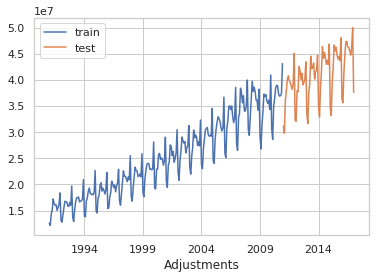

In [9]:
# plot

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

### preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
train.shape, test.shape, train_sc.shape, test_sc.shape

((240, 1), (73, 1), (240, 1), (73, 1))

In [12]:
train_sc_df = pd.DataFrame(data=train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(data=test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()


,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [13]:
X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [14]:
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [15]:
for shift in range(1, 13):
    train_sc_df['shift_{}'.format(shift)] = train_sc_df['Scaled'].shift(shift)
    test_sc_df['shift_{}'.format(shift)] = test_sc_df['Scaled'].shift(shift)


In [16]:
train_sc_df.describe()

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
count,240.000000,239.000000,238.000000,237.000000,236.000000,235.000000,234.000000,233.000000,232.000000,231.000000,230.000000,229.000000,228.000000
mean,0.420985,0.418563,0.416898,0.415272,0.413646,0.411940,0.410008,0.408054,0.406160,0.404522,0.403080,0.402519,0.401664
std,0.241028,0.238588,0.237695,0.236869,0.236042,0.235085,0.233712,0.232292,0.230983,0.230130,0.229584,0.229929,0.230070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.211260,0.210050,0.208841,0.207631,0.207044,0.206457,0.205870,0.205282,0.204648,0.204014,0.203380,0.202746,0.202611
50%,0.387050,0.383386,0.383247,0.383108,0.382566,0.382023,0.380370,0.378716,0.376887,0.375058,0.373580,0.372102,0.371540
75%,0.600857,0.599528,0.598398,0.597349,0.595715,0.593959,0.592390,0.591318,0.591266,0.590253,0.587838,0.589258,0.584998
max,1.000000,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722,0.929722


### make dataset(train, test)

In [17]:
X_train_df = train_sc_df.dropna().drop('Scaled', axis=1)
y_train_df = train_sc_df.dropna()[['Scaled']]

In [18]:
X_test_df = test_sc_df.dropna().drop('Scaled', axis=1)
y_test_df = test_sc_df.dropna()[['Scaled']]

In [19]:
# DataFrame -> ndarray

X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

In [20]:
# 2차원 데이터(size, feature)를 3차원 데이터(size, feature, time)으로.

X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [21]:
X_train.shape, X_train_t.shape, X_test.shape, X_test_t.shape

((228, 12), (228, 12, 1), (61, 12), (61, 12, 1))

### LSTM Modeling

In [23]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [24]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [25]:
# 손실 이력 객체 생성
history = LossHistory() 
history.init()

In [33]:
K.clear_session()

model = Sequential() # Sequential Model
model.add(LSTM(100, input_shape=(12,1))) # (timestamp, feature) 
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=2, callbacks=[history])
y_pred = model.predict(X_test_t)

Epoch 1/100
 - 0s - loss: 0.0013
Epoch 2/100
 - 0s - loss: 0.0014
Epoch 3/100
 - 0s - loss: 0.0013
Epoch 4/100
 - 0s - loss: 0.0014
Epoch 5/100
 - 0s - loss: 0.0014
Epoch 6/100
 - 0s - loss: 0.0012
Epoch 7/100
 - 0s - loss: 0.0012
Epoch 8/100
 - 0s - loss: 0.0012
Epoch 9/100
 - 0s - loss: 0.0012
Epoch 10/100
 - 0s - loss: 0.0014
Epoch 11/100
 - 0s - loss: 0.0014
Epoch 12/100
 - 0s - loss: 0.0014
Epoch 13/100
 - 0s - loss: 0.0011
Epoch 14/100
 - 0s - loss: 0.0011
Epoch 15/100
 - 0s - loss: 0.0012
Epoch 16/100
 - 0s - loss: 0.0010
Epoch 17/100
 - 0s - loss: 0.0010
Epoch 18/100
 - 0s - loss: 0.0010
Epoch 19/100
 - 0s - loss: 0.0011
Epoch 20/100
 - 0s - loss: 0.0011
Epoch 21/100
 - 0s - loss: 0.0015
Epoch 22/100
 - 0s - loss: 0.0017
Epoch 23/100
 - 0s - loss: 0.0014
Epoch 24/100
 - 0s - loss: 9.7109e-04
Epoch 25/100
 - 0s - loss: 9.8319e-04
Epoch 26/100
 - 0s - loss: 9.6371e-04
Epoch 27/100
 - 0s - loss: 0.0011
Epoch 28/100
 - 0s - loss: 9.5221e-04
Epoch 29/100
 - 0s - loss: 0.0010
Epoch 3

### Visualization

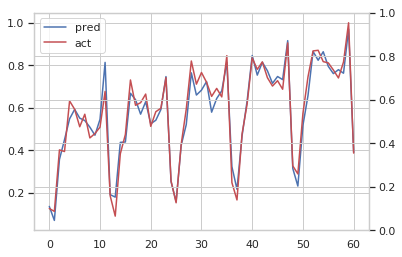

In [39]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
pred = y_pred

loss_ax.plot(pred, 'b', label='pred')
loss_ax.plot(y_test, 'r', label='act')
loss_ax.legend(loc='upper left')

plt.show()

In [40]:
len(history.losses)

300

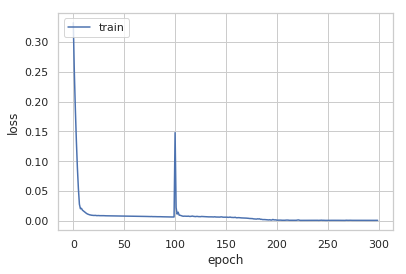

In [41]:
# loss

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 태양광 LSTM
- - -